# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs) 
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a classification neural network 

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a classification network.* ***Source:*** *Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias `tf`. For this notebook, make sure you're using version 2.x+.

In [ ]:
# Enhance the quality of figures
%config InlineBackend.figure_formats=['svg']

In [ ]:
 from sklearn.datasets import make_circles

 # Make 1000 examples
 n_samples = 1000

 # Create circles
 X, y = make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

In [ ]:
# Checkout features
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [ ]:
# Check the labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Okay, we've seen some of our data and labels, how about we move towards visualizing?

> 🔑 **Note:** One important step of starting any kind of machine learning project is to [become one with the data](https://karpathy.github.io/2019/04/25/recipe/). And one of the best ways to do this is to visualize the data you're working with as much as possible. The data explorer's motto is "visualize, visualize, visualize".

We'll start with a DataFrame.

In [ ]:
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


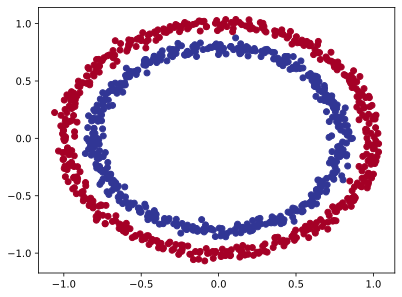

In [ ]:
# Visalize with the plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

> 🛠 **Practice:** Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

## Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `X` and get our model to predict `y`.

So let's check out the shapes of `X` and `y`.

In [ ]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# How many samples we are working with
len(X), len(y)

(1000, 1000)

In [ ]:
# View the first wxample of features and labels
X[4], y[4]

(array([ 0.44220765, -0.89672343]), 0)

Alright, so we've got two `X` features which lead to one `y` value.

This means our neural network input shape will has to accept a tensor with at least one dimension being two and output a tensor with at least one value.

> 🤔 **Note:** `y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension. For now, think of your output shape as being at least the same value as one example of `y` (in our case, the output from our neural network has to be at least one value).

## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 
4. **Tweak** the model
5. **Evaluate the model**

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [ ]:
# Import TensorFlow
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"]) # see evaluatio metrics: https://www.ritchieng.com/machine-learning-evaluate-classification-model/

# 3. Fit the model
model_1.fit(X, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 6s 5ms/step - loss: 4.2718 - accuracy: 0.4760
Epoch 2/5
32/32 [==============================] - 0s 4ms/step - loss: 2.4086 - accuracy: 0.4830
Epoch 3/5
32/32 [==============================] - 0s 4ms/step - loss: 0.7550 - accuracy: 0.4950
Epoch 4/5
32/32 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.4970
Epoch 5/5
32/32 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.4960


In [ ]:
# Let's try and improve our model by training for longer...
model_1.fit(X, y, epochs=200, verbose=0)
model_1.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5000


[0.6934829950332642, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create a model, this time with 2 layers
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0)

In [ ]:
model_2.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6932541131973267, 0.5]

In [ ]:
circles["label"].value_counts()

1    500
0    500
Name: label, dtype: int64

## Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

How about we try adding more neurons, an extra layer and our friend the Adam optimizer?

Surely doing this will result in predictions better than guessing...

> **Note:** The following message (below this one) can be ignored if you're running TensorFlow 2.8.0+, the error seems to have been fixed.

> **Note:** If you're using TensorFlow 2.7.0+ (but not 2.8.0+) the original code from the following cells may have caused some errors. They've since been updated to fix those errors. You can see explanations on what happened at the following resources:
* [Example Colab Notebook](https://colab.research.google.com/drive/1_dlrB_DJOBS9c9foYJs49I0YwN7LTakl?usp=sharing)
* [TensorFlow for Deep Learning GitHub Discussion on TensorFlow 2.7.0 breaking changes](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278)


In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create a model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=0)

In [ ]:
model_3.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6999 - accuracy: 0.5070


[0.6999320387840271, 0.5070000290870667]

In [ ]:
model_3.predict(X)

32/32 [==============================] - 0s 2ms/step


array([[0.48288715],
       [0.57110244],
       [0.5759876 ],
       [0.582093  ],
       [0.43245265],
       [0.58637005],
       [0.56549925],
       [0.47665435],
       [0.47650033],
       [0.5856119 ],
       [0.5210443 ],
       [0.5321352 ],
       [0.57364327],
       [0.4492662 ],
       [0.4417809 ],
       [0.45620635],
       [0.5515734 ],
       [0.45949683],
       [0.55923146],
       [0.5085933 ],
       [0.50423104],
       [0.6024094 ],
       [0.4548574 ],
       [0.4866739 ],
       [0.59928924],
       [0.58509374],
       [0.5578928 ],
       [0.45469046],
       [0.45184577],
       [0.44581285],
       [0.47863477],
       [0.59016573],
       [0.5629192 ],
       [0.45391762],
       [0.45464766],
       [0.60606784],
       [0.5852934 ],
       [0.5315569 ],
       [0.45287997],
       [0.5087484 ],
       [0.50405544],
       [0.55063516],
       [0.51712203],
       [0.44881016],
       [0.5305269 ],
       [0.5495418 ],
       [0.44039968],
       [0.549

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

Still! 

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's happening.

> 🔑 **Note:** Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **visualize, visualize, visualize**. Inspect your data, inspect your model, inpsect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

If this sounds confusing, let's see it in code and then see the output.

> 🔑 **Note:** If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [ ]:
# Import NumPy
import numpy as np

In [ ]:
def plot_decision_boundry(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundries of the plot and create a meshgird
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 1].max() + 0.1
  y_min, y_max = X[:, 0].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X value (we are going to make prediction on these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together

  # Make predictions 
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("Doing multi-class classification")
    # We have to reshape our prediction to get them ready fpr plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("Doing Binary classification")
    y_pred = np.round(y_pred).reshape(xx.shape)

  # Plot the decision boundry
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

313/313 [==============================] - 0s 1ms/step
Doing Binary classification


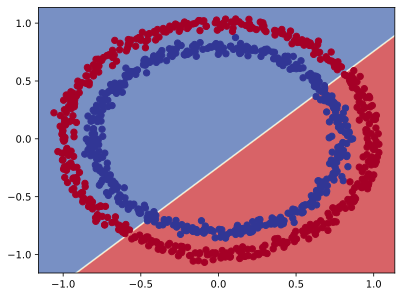

In [ ]:
# Check ou tthe predictions our model is making
plot_decision_boundry(model=model_3,
                      X=X,
                      y=y)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create a model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation="relu"), # add 100 dense neurons
  tf.keras.layers.Dense(10, activation="relu"), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
model_4.fit(X, y, epochs=100, verbose=0)

In [ ]:
model_4.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000


[0.0031328906770795584, 1.0]

313/313 [==============================] - 1s 2ms/step
Doing Binary classification


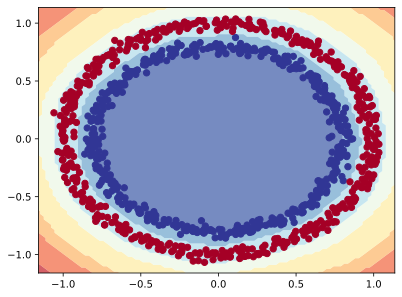

In [ ]:
# Check ou tthe predictions our model is making
plot_decision_boundry(model=model_4,
                      X=X,
                      y=y)

Looks like our model_3 is trying to draw a straight line through the data.

What's wrong with doing this?

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work. In fact, let's try it.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

# # Fit our model to the regression data
# model_3.fit(X_reg_train, y_reg_train, epochs=100)

Oh wait... we compiled our model for a binary classification problem.

No trouble, we can recreate it for a regression problem.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# 2. Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# 3. Fit the model
model_3.fit(tf.expand_dims(X_reg_train, axis=-1), 
            y_reg_train, 
            epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 6ms/step - loss: 474.4096 - mae: 474.4096
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 381.0628 - mae: 381.0628
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 290.9355 - mae: 290.9355
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 197.0550 - mae: 197.0550
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 98.5525 - mae: 98.5525
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 52.7748 - mae: 52.7749
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 75.6807 - mae: 75.6807
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 62.9392 - mae: 62.9392
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 44.7288 - mae: 44.7288
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 48.6000 - mae: 48.6000
Epoch 11/100
5/5 [==============================] -

2/2 [==============================] - 0s 7ms/step


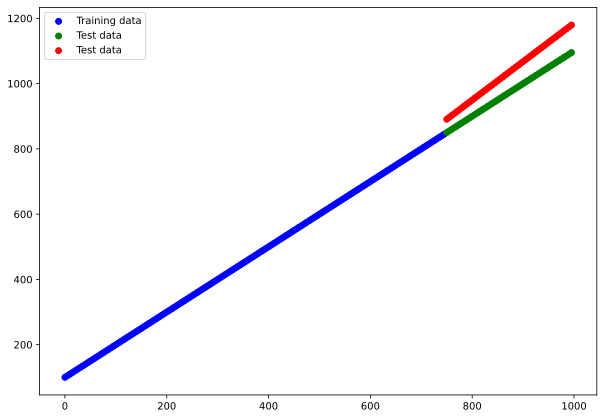

In [ ]:
# Make prediction
y_reg_preds = model_3.predict(X_reg_test)

# Plot the model's prediction
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c="b", label="Training data")
plt.scatter(X_reg_test, y_reg_test, c="g", label="Test data")
plt.scatter(X_reg_test, y_reg_preds, c="r", label="Test data")
plt.legend()

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something...

There must be something we're missing out on for our classification problem.

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and clue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.


In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)])

# 2. Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 4ms/step - loss: 6.0643 - accuracy: 0.4800
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0571 - accuracy: 0.4800
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0469 - accuracy: 0.4800
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0439 - accuracy: 0.4800
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0416 - accuracy: 0.4800
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0399 - accuracy: 0.4800
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0384 - accuracy: 0.4800
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0367 - accuracy: 0.4800
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0151 - accuracy: 0.4810
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 6.0020 - accuracy: 0.4820
Epoch 11/

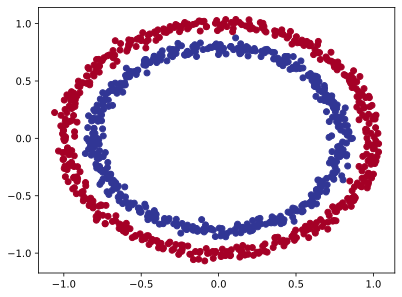

In [ ]:
# Check out ourdata
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

313/313 [==============================] - 0s 1ms/step
Doing Binary classification


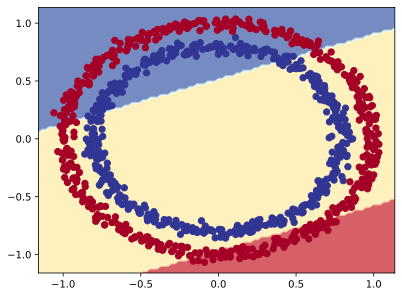

In [ ]:
# Check the decision boundry for our latest model
plot_decision_boundry(model=model_4,
                      X=X,
                      y=y)

Well, it looks like we're getting a straight (linear) line prediction again. 

But our data is non-linear (not a straight line)...

What we're going to have to do is add some non-linearity to our model.

To do so, we'll use the `activation` parameter in on of our layers.


Activation function for NN:
https://www.v7labs.com/blog/neural-networks-activation-functions

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)])

# 2. Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=0.01),
                metrics=["accuracy"])

# 3. Fit the model
history = model_5.fit(X, y, epochs=100);

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 5.1223 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 4.1872 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 3.8956 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 3.7271 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 3.4736 - accuracy: 0.4520
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 3.3234 - accuracy: 0.4160
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 3.1579 - accuracy: 0.4360
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 2.9220 - accuracy: 0.4590
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 2.8158 - accuracy: 0.4650
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 2.7009 - accuracy: 0.4650
Epoch 11/

313/313 [==============================] - 0s 1ms/step
Doing Binary classification


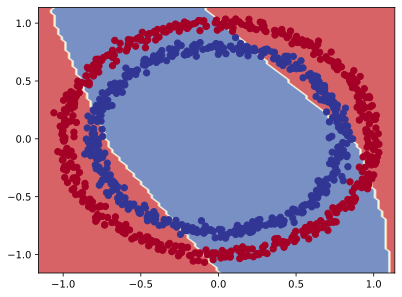

In [ ]:
plot_decision_boundry(model=model_5,
                      X=X,
                      y=y)

In [ ]:
# Time to replicate the multi-layer NN from tensorFlow

# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# 3. Fit the model
history = model_6.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 4ms/step - loss: 5.8058 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 4.6151 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 2.4404 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 1.1959 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 1.1306 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0885 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0530 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 4ms/step - loss: 1.0211 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 4ms/step - loss: 0.9933 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9675 - accuracy: 0.5000
Epoch 11/

313/313 [==============================] - 1s 1ms/step
Doing Binary classification


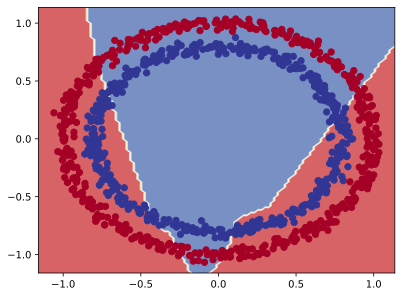

In [ ]:
# plot decision boundry
plot_decision_boundry(model=model_6,
                      X=X,
                      y=y)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # See useage of activation function: https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c#:~:text=The%20output%20layer%20activation%20function,activation%20function%20with%20one%20node.
])

# 2. Compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

# 3. Fit the model
history = model_7.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 4ms/step - loss: 0.6966 - accuracy: 0.5150
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5230
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.5470
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5950
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.5480
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6400
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6670
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6006 - accuracy: 0.7120
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5480 - accuracy: 0.7980
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4977 - accuracy: 0.8260
Epoch 11/

In [ ]:
# 4. evaluate the model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9960


[0.0294868852943182, 0.9959999918937683]

313/313 [==============================] - 1s 1ms/step
Doing Binary classification


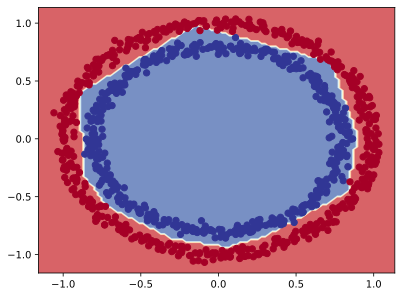

In [ ]:
# Let's visualize out metrics
plot_decision_boundry(model=model_7,
                      X=X,
                      y=y)

See the link about using avtivation functions: 

https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c#:~:text=The%20output%20layer%20activation%20function,activation%20function%20with%20one%20node.

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [ ]:
# Create a toy tensor (similar to the data we pass into pur models)
A = tf.cast(tf.range(-10, 10), tf.float64)
A

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])>

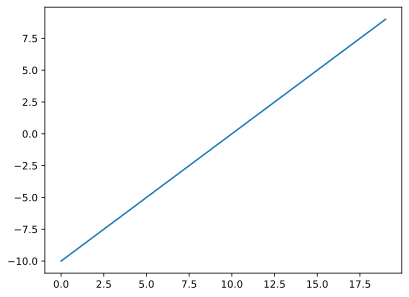

In [ ]:
# visualize our toy tensor
plt.plot(A)

In [ ]:
# Let's start by replicating sigmoid - sigmoid(x) = 1 / (1 + exp(-x))
def sigmoid(x):
  return 1/(1 + tf.math.exp(-x))

# Use the sigmoid function on our toy tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([4.53978687e-05, 1.23394576e-04, 3.35350130e-04, 9.11051194e-04,
       2.47262316e-03, 6.69285092e-03, 1.79862100e-02, 4.74258732e-02,
       1.19202922e-01, 2.68941421e-01, 5.00000000e-01, 7.31058579e-01,
       8.80797078e-01, 9.52574127e-01, 9.82013790e-01, 9.93307149e-01,
       9.97527377e-01, 9.99088949e-01, 9.99664650e-01, 9.99876605e-01])>

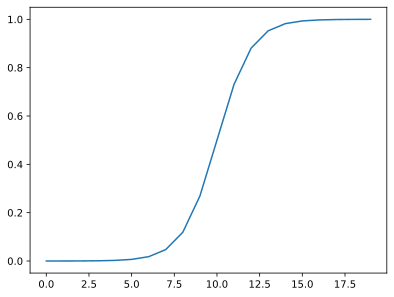

In [ ]:
# Plot aour toy tensor transformed by sigmoid function
plt.plot(sigmoid(A))

In [ ]:
# Let's recreate ReLu Function
def relu(x):
  return tf.maximum(0, x)

# Pass our toy tensor to our relu function
relu(A)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.])>

In [ ]:
A

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])>

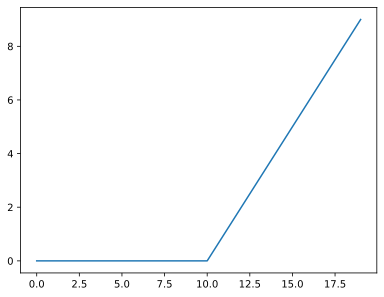

In [ ]:
# Plot the relu function result
plt.plot(relu(A))

In [ ]:
# Let's try linear activation function
def linear(x):
  return x

In [ ]:
linear(A)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])>

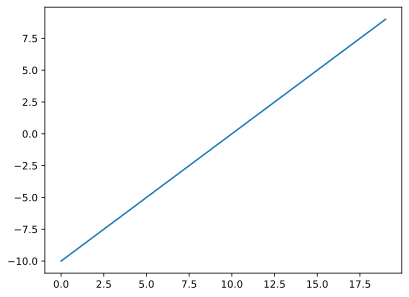

In [ ]:
# Does the linear activation function change anything?
plt.plot(tf.keras.activations.linear(A))

In [ ]:
# Does anything changed?
A == tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

See the cheatsheet for activation functions:

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

## Evaluating and improving our classification model

If you answered the question above, you might've picked up what we've been doing wrong.

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

Let's do it.

In [ ]:
# Check how many examples we have
len(X)

1000

In [ ]:
# Split inoto train and test sets
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [ ]:
# Recreate the model to fit on the training data

# Set the random seed
tf.random.set_seed(42)

# 1. Create the model (same as model 7)
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compile the model
model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])
# 3. Fit the model
history = model_8.fit(X_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 0.6841 - accuracy: 0.5550
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.5738
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.5938
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.7237
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.7312
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5807 - accuracy: 0.7337
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5389 - accuracy: 0.7812
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5066 - accuracy: 0.7875
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4581 - accuracy: 0.8425
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4160 - accuracy: 0.8800
Epoch 11/

In [ ]:
# Evaluate the model on the test dataset
model_8.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0574 - accuracy: 0.9850


[0.0573558583855629, 0.9850000143051147]

313/313 [==============================] - 1s 1ms/step
Doing Binary classification
313/313 [==============================] - 0s 1ms/step
Doing Binary classification


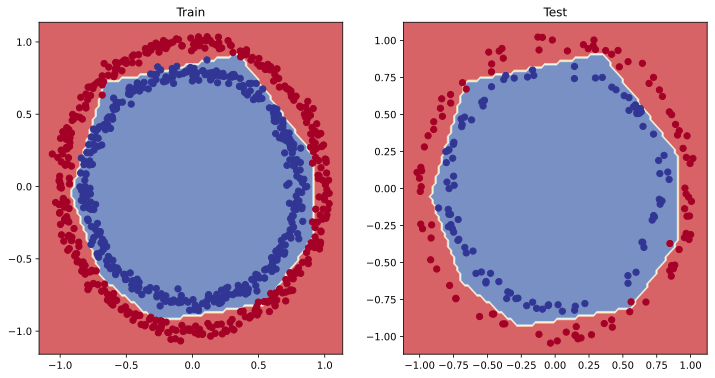

In [ ]:
# Plot the decision boundry with traininf and test datasets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundry(model_8, X=X_train, y=y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundry(model_8, X=X_test, y=y_test)

## Plot the loss (or training) curves

Looking at the plots above, we can see the outputs of our model are very good.

But how did our model go whilst it was learning?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the **loss curves** (also referred to as the **learning curves**).

You might've seen we've been using the variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

This is where we'll get the information for how our model is performing as it learns.

Let's see how we might use it.

In [ ]:
# Convert a history object into dataframw
pd.DataFrame(history.history)

,loss,accuracy
0,0.684074,0.55500
1,0.676916,0.57375
2,0.666877,0.59375
3,0.648696,0.72375
4,0.623718,0.73125
...,...,...
95,0.031260,0.99250
96,0.030836,0.99250
97,0.033843,0.99125
98,0.049178,0.98250


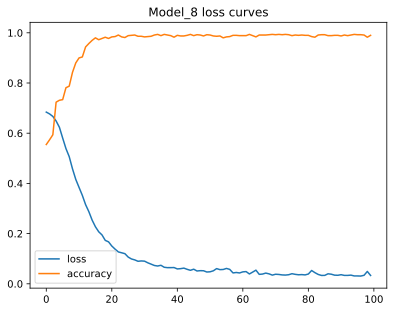

In [ ]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_8 loss curves");

Beautiful. This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up.

> 🔑 **Note:** For many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to the ground truth labels).

## Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important hyperparameter you can tune for your neural network models is the **learning rate**.

In `model_8` you saw we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01`.

And you might be wondering why we did this.

Put it this way, it was a lucky guess.

I just decided to try a lower learning rate and see how the model went.

Now you might be thinking, "Seriously? You can do that?"

And the answer is yes. You can change any of the hyperparamaters of your neural networks.

With practice, you'll start to see what kind of hyperparameters work and what don't.

That's an important thing to understand about machine learning and deep learning in general. It's very experimental. You build a model and evaluate it, build a model and evaluate it.

That being said, I want to introduce you a trick which will help you find the optimal learning rate (at least to begin training with) for your models going forward.

To do so, we're going to use the following:
* A [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
   * You can think of a callback as an extra piece of functionality you can add to your model *while* its training.
* Another model (we could use the same ones as above, we we're practicing building models here).
* A modified loss curves plot.

We'll go through each with code, then explain what's going on.

> 🔑 **Note:** The default hyperparameters of many neural network building blocks in TensorFlow are setup in a way which usually work right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) default settings can usually get good results on many datasets). So it's a good idea to try the defaults first, then adjust as needed.

In [ ]:
#Set random seed
tf.random.set_seed(42)

# Create the model (same a model_8)
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_9.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Create a learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

 # Fit the model (passing lr_scheduler callback)
history_9 = model_9.fit(X_train, 
                       y_train,
                       epochs=100,
                       callbacks=[lr_scheduler])

Epoch 1/100
25/25 [==============================] - 2s 5ms/step - loss: 0.7184 - accuracy: 0.4850 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7177 - accuracy: 0.4863 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7170 - accuracy: 0.4863 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7162 - accuracy: 0.4888 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.4888 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7146 - accuracy: 0.4875 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7137 - accuracy: 0.4850 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7129 - accuracy: 0.4775 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 4ms/step - loss:

<Axes: xlabel='epochs'>

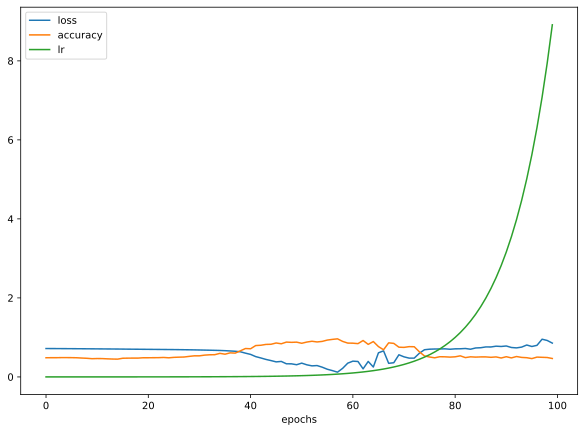

In [ ]:
# Checkout the history
pd.DataFrame(history_9.history).plot(figsize=(10, 7), xlabel="epochs")

In [ ]:
np.min(history_9.history["loss"])

0.12017165124416351

In [ ]:
tf.range(100)/20

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
       3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
       3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
       4.95])>

Text(0.5, 1.0, 'Learning rate vs. Loss')

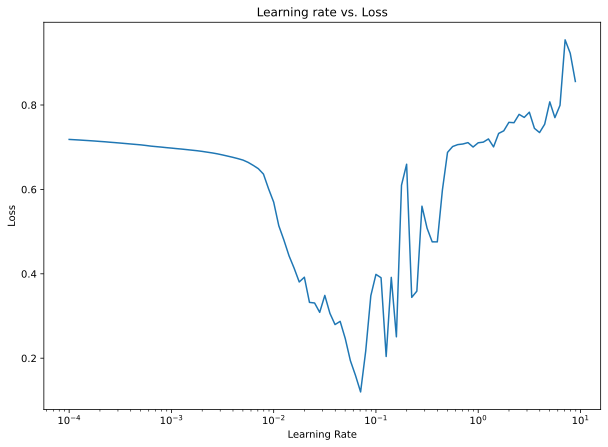

In [ ]:
# Plot the learning rate versus the loss
lrs = 1e-4 * 10**(tf.range(100)/20)
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_9.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. Loss")

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).

In [ ]:
# Example of other typical learning rate values
10**0, 10**-1, 10**-2, 10**-3, 1e-4

(1, 0.1, 0.01, 0.001, 0.0001)

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it.

In [ ]:
# Let's try using a higher *ideal* learning rate

# Set random seed
tf.random.set_seed(42)

# Create the model
model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_10.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.02),
                 metrics=["accuracy"])

# Fit the model for 20 epochs
history_10 = model_10.fit(X_train, y_train, epochs=80)

Epoch 1/80
25/25 [==============================] - 1s 3ms/step - loss: 0.6925 - accuracy: 0.5075
Epoch 2/80
25/25 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5150
Epoch 3/80
25/25 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5163
Epoch 4/80
25/25 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5213
Epoch 5/80
25/25 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5200
Epoch 6/80
25/25 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5213
Epoch 7/80
25/25 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5250
Epoch 8/80
25/25 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5250
Epoch 9/80
25/25 [==============================] - 0s 5ms/step - loss: 0.6860 - accuracy: 0.5300
Epoch 10/80
25/25 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5275
Epoch 11/80
25/25 [

In [ ]:
model_10.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.2522 - accuracy: 0.9800


[0.2521900236606598, 0.9800000190734863]

In [ ]:
model_8.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0574 - accuracy: 0.9850


[0.0573558583855629, 0.9850000143051147]

313/313 [==============================] - 1s 2ms/step
Doing Binary classification
313/313 [==============================] - 1s 2ms/step
Doing Binary classification


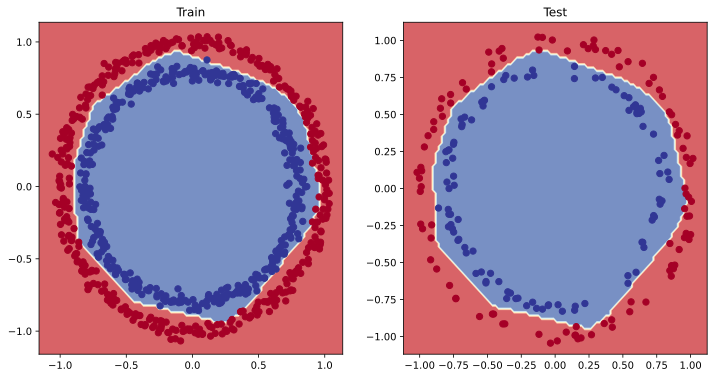

In [ ]:
# Plot the decision bounries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundry(model_10, X=X_train, y=y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundry(model_10, X=X_test, y=y_test)

And as we can see, almost perfect again.

These are the kind of experiments you'll be running often when building your own models.

Start with default settings and see how they perform on your data.

And if they don't perform as well as you'd like, improve them.

Let's look at a few more ways to evaluate our classification models.

## More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

> 🔑 **Note:** Every classification problem will require different kinds of evaluation methods. But you should be familiar with at least the ones above.

Let's start with accuracy.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.

In [ ]:
# Check the accuracu of our model
loss, accuracy = model_10.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {accuracy}")

7/7 [==============================] - 0s 3ms/step - loss: 0.2522 - accuracy: 0.9800
Model loss on the test set: 0.2521900236606598
Model accuracy on the test set: 0.9800000190734863


How about a confusion matrix?

![anatomy of a confusion matrix](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-anatomy-of-a-confusion-matrix.png)
*Anatomy of a confusion matrix (what we're going to be creating). Correct predictions appear down the diagonal (from top left to bottom right).*

We can make a confusion matrix using [Scikit-Learn's `confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method.

In [ ]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_preds = model_10.predict(X_test)

# # Create confusion matrix
# confusion_matrix(y_test, y_preds)

7/7 [==============================] - 0s 2ms/step


In [ ]:
y_test[:10]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

In [ ]:
y_preds[:10]

array([[0.7387401 ],
       [0.8237731 ],
       [0.70707726],
       [0.9099511 ],
       [0.26626217],
       [0.16498229],
       [0.87624305],
       [0.11762097],
       [0.6994125 ],
       [0.4472105 ]], dtype=float32)

Ahh, it seems our predictions aren't in the format they need to be.

Let's check them out.

It looks like we need to get our predictions into the binary format (0 or 1).

But you might be wondering, what format are they currently in?

In their current format (`9.8526537e-01`), they're in a form called **prediction probabilities**.

You'll see this often with the outputs of neural networks. Often they won't be exact values but more a probability of how *likely* they are to be one value or another.

So one of the steps you'll often see after making predicitons with a neural network is converting the prediction probabilities into labels.

In our case, since our ground truth labels (`y_test`) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [ ]:
# Convert prediction probabilities to binary format and view the first 10
tf.round(y_preds)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [ ]:
# Create a confusion metrix 
confusion_matrix(y_test, tf.round(y_preds))

array([[97,  4],
       [ 0, 99]])

Alright, we can see the highest numbers are down the diagonal (from top left to bottom right) so this a good sign, but the rest of the matrix doesn't really tell us much.

How about we make a function to make our confusion matrix a little more visual?

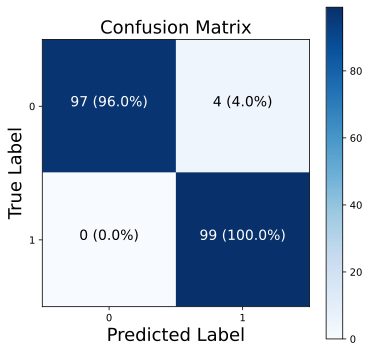

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize = (6, 6)

# Create the confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds)) 
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize of confusion matrix
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)

# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted Label",
       ylabel="True Label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set axis label to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.title.set_fontsize(18)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the test on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=14)


In [ ]:
# What does itertools.product do? Combines two things into each combination
import itertools
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  print(i, j)

0 0
0 1
1 0
1 1


In [ ]:
import itertools
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  print(j, i)

0 0
1 0
0 1
1 1


# Working with a larger example (multiclass classification)

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as **multiclass classification**.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

Let's see it in action.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as [Fashion MNIST built-in](https://github.com/zalandoresearch/fashion-mnist). Meaning we can get started straight away.

see Tensordlow MNISt fashion: https://www.tensorflow.org/datasets/catalog/fashion_mnist

We can import it using the [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) module.

> 📖 **Resource:** The following multiclass classification problem has been adapted from the [TensorFlow classification guide](https://www.tensorflow.org/tutorials/keras/classification). A good exercise would be to once you've gone through the following example, replicate the TensorFlow guide.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Teh data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n")
print(f"Training label:\n{train_labels[0]}\n")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

In [ ]:
# Check the shape ofa single example
train_data[0].shape, train_labels[0].shape

((28, 28), ())

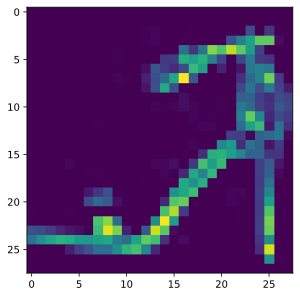

In [ ]:
# Plot a single sample
import matplotlib.pyplot as plt
plt.imshow(train_data[8]);

In [ ]:
# Check our sample labels
train_labels[8]

5

In [ ]:
# Create a small list so we can index onto our training labels so they are human-readable
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)

10

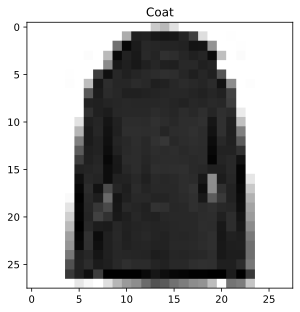

In [ ]:
# Plot an example image and its label
index_of_choice = 2000
plt.imshow(train_data[index_of_choice], cmap=plt.cm.binary)
plt.title(class_names[train_labels[index_of_choice]]);

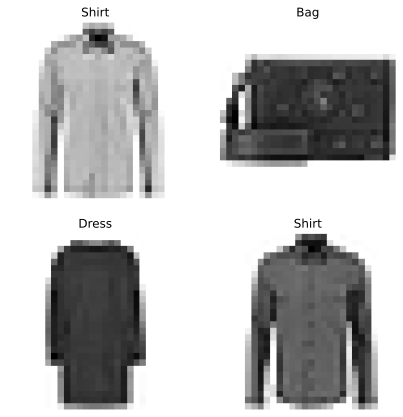

In [ ]:
# Plot multiple random images of fashion MNIST
 
import random
plt.figure(figsize=(7, 7))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)

Alright, let's build a model to figure out the relationship between the pixel values and their labels.

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture (inline with Table 1 above):

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function. 
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.

You ready? Let's go.

In [ ]:
train_data[0].shape

(28, 28)

In [ ]:
len(class_names)

10

In [ ]:
tf.one_hot(train_labels[:10], depth=10)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# our data need to be flatten (from 28 *28 to None, 784)
flatten_data = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28))])
flatten_data.output_shape

(None, 784)

In [ ]:
28 * 28

784

In [ ]:
# Set random see
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

# Compile the model
model_11.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
non_norm_history = model_11.fit(train_data,
                                train_labels,
                                epochs=10,
                                validation_data=(test_data, test_labels))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 2.3276 - accuracy: 0.1098 - val_loss: 2.2188 - val_accuracy: 0.1334
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2414 - accuracy: 0.1257 - val_loss: 2.2125 - val_accuracy: 0.1355
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.9508 - accuracy: 0.2321 - val_loss: 1.7622 - val_accuracy: 0.2388
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7123 - accuracy: 0.2573 - val_loss: 1.6860 - val_accuracy: 0.2631
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6597 - accuracy: 0.2691 - val_loss: 1.6537 - val_accuracy: 0.2601
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6210 - accuracy: 0.2733 - val_loss: 1.6216 - val_accuracy: 0.2830
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6118 - accuracy: 0.2799 - val_loss: 1.6021 - val_accuracy:

In [ ]:
# Set random see
tf.random.set_seed(42)

# Create the model
model_111 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

# Compile the model
model_111.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
non_norm_history1 = model_111.fit(train_data,
                                tf.one_hot(train_labels, depth=10),
                                epochs=10,
                                validation_data=(test_data, tf.one_hot(test_labels, depth=10)))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 2.4658 - accuracy: 0.0994 - val_loss: 2.3011 - val_accuracy: 0.1010
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2970 - accuracy: 0.1026 - val_loss: 2.4343 - val_accuracy: 0.1352
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 2.1419 - accuracy: 0.1677 - val_loss: 1.8652 - val_accuracy: 0.2298
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7698 - accuracy: 0.2356 - val_loss: 1.8003 - val_accuracy: 0.2133
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6861 - accuracy: 0.2561 - val_loss: 1.6570 - val_accuracy: 0.2726
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6465 - accuracy: 0.2662 - val_loss: 1.6302 - val_accuracy: 0.2731
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6308 - accuracy: 0.2694 - val_loss: 1.6260 - val_accuracy:

In [ ]:
model_11.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_46 (Dense)            (None, 4)                 3140      
                                                                 
 dense_47 (Dense)            (None, 4)                 20        
                                                                 
 dense_48 (Dense)            (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Check the min and max values of trained data
train_data.min(), train_data.max()

(0, 255)

Alright, our model gets to about ~35% accuracy after 10 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy) but we can do better.

Do you remember when we talked about neural networks preferring numbers between 0 and 1? (if not, treat this as a reminder)

Well, right now, the data we have isn't between 0 and 1, in other words, it's not normalized (hence why we used the `non_norm_history` variable when calling `fit()`). It's pixel values are between 0 and 255.

Let's see.

We can get these values between 0 and 1 by dividing the entire array by the maximum: `255.0` (dividing by a float also converts to a float).


Doing so will result in all of our data being between 0 and 1 (known as **scaling** or **normalization**).

In [ ]:
train_data_norm = train_data / 255.0
test_data_norm = test_data / 255.0

# Check the min and max values of the scaled training data
train_data_norm.min(), train_data_norm.max()

(0.0, 1.0)

In [ ]:
# Now our data is normalized, let's build a model to find patterns in it

# Set random seed
tf.random.set_seed(42)

# Create a model 
model_12 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax),
])

# Complie the model
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the molel
norm_history = model_12.fit(train_data_norm,
                            train_labels,
                            epochs=10,
                            validation_data=(test_data_norm, test_labels))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.4483 - accuracy: 0.4587 - val_loss: 0.8927 - val_accuracy: 0.6738
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7639 - accuracy: 0.7324 - val_loss: 0.7231 - val_accuracy: 0.7514
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6631 - accuracy: 0.7767 - val_loss: 0.6721 - val_accuracy: 0.7696
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6129 - accuracy: 0.7986 - val_loss: 0.6323 - val_accuracy: 0.7894
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5903 - accuracy: 0.8047 - val_loss: 0.6178 - val_accuracy: 0.7905
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5736 - accuracy: 0.8112 - val_loss: 0.6154 - val_accuracy: 0.7954
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5639 - accuracy: 0.8140 - val_loss: 0.6090 - val_accuracy:

Woah, we used the exact same model as before but we with normalized data we're now seeing a much higher accuracy value!

Let's plot each model's history (their loss curves).

<Axes: title={'center': 'Normalized data'}>

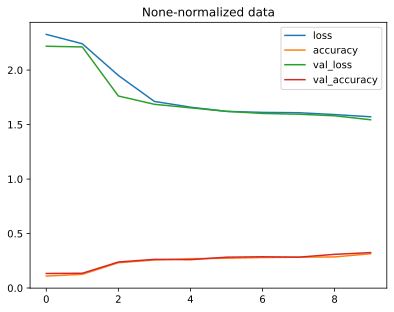

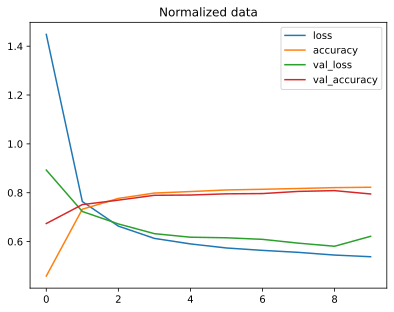

In [ ]:
 import pandas as pd
 # Plot the non-normalized data loss curves
 pd.DataFrame(non_norm_history.history).plot(title="None-normalized data")
 # Plot normalized data loss curve
 pd.DataFrame(norm_history.history).plot(title="Normalized data")

Wow. From these two plots, we can see how much quicker our model with the normalized data (`model_12`) improved than the model with the non-normalized data (`model_11`).

> 🔑 **Note:** The same model with even *slightly* different data can produce *dramatically* different results. So when you're comparing models, it's important to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture).

How about we find the ideal learning rate and see what happens?

We'll use the same architecture we've been using.

## Finding the ideal learning rate

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_13 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model_13.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
find_lr_history = model_13.fit(train_data_norm,
                               train_labels,
                               epochs=40,
                               validation_data=(test_data_norm, test_labels),
                               callbacks=[lr_scheduler])

Epoch 1/40
1875/1875 [==============================] - 9s 3ms/step - loss: 1.3228 - accuracy: 0.4762 - val_loss: 0.9731 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 2/40
1875/1875 [==============================] - 7s 3ms/step - loss: 0.8933 - accuracy: 0.6465 - val_loss: 0.8525 - val_accuracy: 0.6755 - lr: 0.0011
Epoch 3/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7548 - accuracy: 0.7311 - val_loss: 0.7204 - val_accuracy: 0.7466 - lr: 0.0013
Epoch 4/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6863 - accuracy: 0.7556 - val_loss: 0.6842 - val_accuracy: 0.7631 - lr: 0.0014
Epoch 5/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6560 - accuracy: 0.7654 - val_loss: 0.6494 - val_accuracy: 0.7722 - lr: 0.0016
Epoch 6/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6347 - accuracy: 0.7755 - val_loss: 0.6627 - val_accuracy: 0.7725 - lr: 0.0018
Epoch 7/40
1875/1875 [==============================] - 8s

Text(0.5, 1.0, 'Findning the ideal learning rate')

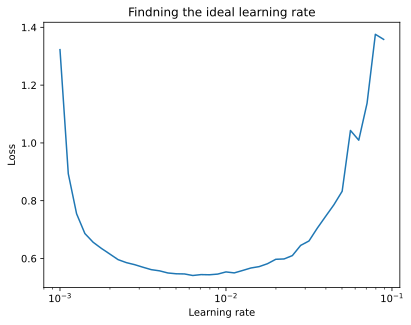

In [ ]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt

lrs = 1e-3 * 10**(tf.range(40)/20)
plt.semilogx(lrs, find_lr_history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Findning the ideal learning rate")

In this case, it looks like somewhere close to the default learning rate of the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) (`0.001`) is the ideal learning rate.

Let's refit a model using the ideal learning rate.

In [ ]:
# Let's refit the model woth the ideal learning rate

# Set random sed
tf.random.set_seed(42)

# Create the model
model_14 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model_14.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.001),
                 metrics=["accuracy"])

# Fit the model
history_14 = model_14.fit(train_data_norm,
                          train_labels,
                          epochs=40,
                          validation_data=(test_data_norm, test_labels))

Epoch 1/40
1875/1875 [==============================] - 9s 4ms/step - loss: 1.1619 - accuracy: 0.4958 - val_loss: 0.8389 - val_accuracy: 0.6728
Epoch 2/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7419 - accuracy: 0.7260 - val_loss: 0.7338 - val_accuracy: 0.7393
Epoch 3/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6765 - accuracy: 0.7551 - val_loss: 0.6897 - val_accuracy: 0.7513
Epoch 4/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6431 - accuracy: 0.7682 - val_loss: 0.6533 - val_accuracy: 0.7621
Epoch 5/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6261 - accuracy: 0.7735 - val_loss: 0.6517 - val_accuracy: 0.7653
Epoch 6/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6143 - accuracy: 0.7775 - val_loss: 0.6448 - val_accuracy: 0.7693
Epoch 7/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6075 - accuracy: 0.7804 - val_loss: 0.6293 - val_accuracy:

## Evaluating our multiclass classification model

Now we've got a model trained with a close-to-ideal learning rate and performing pretty well, we've got a couple of options.

We could:
* Evaluate its performance using other classification metrics (such as a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) or [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)).
* Assess some of its predictions (through visualizations).
* Improve its accuracy (by training it for longer or changing the architecture).
* Save and export it for use in an application.

Let's go through the first two options.

First we'll create a classification matrix to visualize its predictions across the different classes.